In [7]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
from torchvision import models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import matplotlib.pyplot as plotter_lib
pin_memory=False
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
torch.autograd.set_detect_anomaly(True)

In [8]:
print(torch.cuda.is_available())

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(torch.cuda.get_device_name(cuda_id))


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#pil verison fix
import PIL

from PIL import __version__
print(__version__)

from PIL import __version__
PIL.PILLOW_VERSION = __version__

print(PIL.PILLOW_VERSION)


True
NVIDIA GeForce GTX 1650 with Max-Q Design
9.4.0
9.4.0


In [9]:
import torchvision
torchvision.__version__

'0.15.1+cpu'

In [10]:
# Define the data transforms to be applied to the images
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [11]:
import os
from PIL import Image
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, root_dir, mode, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode
        
        # create a list of image paths and labels for the specified mode (train or test)
        self.image_paths = []
        self.labels = []
        class_names = ['DME', 'DRUSEN']
        class_labels = [1, 0]
        for i, class_name in enumerate(class_names):
            class_path = os.path.join(self.root_dir, self.mode, class_name)
            class_label = class_labels[i]
            
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                self.image_paths.append(image_path)
                self.labels.append(class_label)
                    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        
        image_1 = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image_1 = self.transform(image_1)
            
        image_2 = transforms.Resize(size=32)(image_1)

        return image_1, image_2, label

In [ ]:
main_dir= r'C:\Users\kjbua\Dropbox\PC\Downloads\Midterm folder for Biomed\Data1'

#loading all images from the train and test directories
image_datasets = {
    'train': CustomDataset(root_dir=main_dir, transform=train_transform, mode='train'),
    'test': CustomDataset(root_dir=main_dir, transform=test_transform, mode = 'test')
}

#loading train and test images using DataLoader
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=os.cpu_count()),    
    'test': DataLoader(image_datasets['test'], batch_size=32, shuffle=False, num_workers=os.cpu_count())
}

# Get image and label from test data loader
image_2, image_1, labels = next(iter(dataloaders['train']))

# Print the shape of the image tensor and label tensor
print(f"Image shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {labels.shape}")

print(f"Number of images in train set: {len(image_datasets['train'])}")
print(f"Number of images in test set: {len(image_datasets['test'])}")



In [27]:
print(image_2.shape)
print(image_1.shape)

NameError: name 'image_2' is not defined

C:\Users\kjbua\PycharmProjects\pythonProject\venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


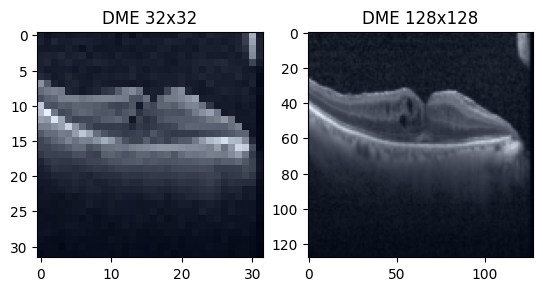

In [7]:
import matplotlib.pyplot as plt

# Define labels

definitions = {0:"DRUSEN", 1:"DME"}

# Get one sample from the training set

sample_low, sample_high, label = image_datasets['train'][0]

# Images conversion to numpy arrays and permute the dimensions
sample_low = np.array(sample_low.permute(1, 2, 0))

sample_high = np.array(sample_high.permute(1, 2, 0))

# Normalize pixel values to the range [0, 1]

sample_low = (sample_low - sample_low.min()) / (sample_low.max() - sample_low.min())

sample_high = (sample_high - sample_high.min()) / (sample_high.max() - sample_high.min())

# Plot the images
fig, axes = plt.subplots(nrows=1, ncols=2)

axes[0].imshow(sample_low)

axes[0].set_title(f"{definitions[label]} 32x32")

axes[1].imshow(sample_high)

axes[1].set_title(f"{definitions[label]} 128x128")

plt.show()


In [8]:
def visualize_images(lr_image, hr_image, generated_image, label, epoch, pretrain, show=False):
    # Move the tensors to the CPU and detach the generated_image tensor
    lr_image = lr_image.cpu().detach().permute(1, 2, 0).numpy()

    hr_image = hr_image.cpu().detach().permute(1, 2, 0).numpy()
    
    generated_image = generated_image.cpu().detach().permute(1, 2, 0).numpy()

    # Normalize the pixel values to the range [0, 1] for visualization
    lr_image = (lr_image - lr_image.min()) / (lr_image.max() - lr_image.min())
    hr_image = (hr_image - hr_image.min()) / (hr_image.max() - hr_image.min())
    generated_image = (generated_image - generated_image.min()) / (generated_image.max() - generated_image.min())

    # Plot the images
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
    axes[0].imshow(lr_image)
    axes[0].set_title("Low Resolution")
    axes[1].imshow(hr_image)
    axes[1].set_title("High Resolution")
    axes[2].imshow(generated_image)
    axes[2].set_title("Generated Image")

    # Add a common title to the figure
    if pretrain:
        fig.suptitle(f"Pre-Training - Epoch {epoch} - {label}")
    else:
        fig.suptitle(f"Epoch {epoch} - {label}")
    
    # Create the 'output' directory if it doesn't exist
    if not os.path.exists('./output'):
        os.makedirs('./output')
    
    # Save and show the figure every 5 epochs
    if epoch % 5 == 0:
        fig.savefig(f"./output/epoch_{epoch}_{label}.png")
        plt.show()
    else:
        plt.close(fig)


In [9]:
class Residual(nn.Module):
    def __init__(self, num_channels, stride=1):
        super().__init__()
        self.num_channels = num_channels
        
        self.body = nn.Sequential(
            nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=stride),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            
            nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=stride),
            nn.LazyBatchNorm2d()
        )
        
        self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=stride)
        
    def forward(self, x):
        
        out = self.body(x)
        
        if self.num_channels != x.shape[1]:
            x = self.conv3(x)
        else:
            self.conv3 = None
            
        out += x 
        
        return out

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.generator = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=9, stride=1, padding=4),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(64),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(64, kernel_size=3, padding=1, stride=1),
            nn.LazyBatchNorm2d(),
            nn.PReLU(),
            
            nn.LazyConv2d(256, kernel_size=3, padding=1, stride=1),
            torch.nn.PixelShuffle(2),
            nn.PReLU(),
            
            nn.LazyConv2d(256, kernel_size=3, padding=1, stride=1),
            torch.nn.PixelShuffle(2),
            nn.PReLU(),
            
            nn.LazyConv2d(3, kernel_size=9, stride=1, padding=4),
        )

    def forward(self, x):
        out = self.generator(x)

        return out


In [11]:
generator = Generator().to(device)
test_input = torch.rand(1,3,32,32).to(device)
print(generator(test_input).shape)

C:\Users\kjbua\PycharmProjects\pythonProject\venv\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([1, 3, 128, 128])


In [12]:
class PretrainGeneratorLoss(nn.Module):
    def __init__(self):
        super(PretrainGeneratorLoss, self).__init__()
        self.pre_train = True
        self.mse_loss = nn.MSELoss()

    def forward(self, sr, hr):
        # Calculate the MSE loss between the super-resolved image and the high-resolution image
        content_loss = self.mse_loss(sr, hr)
        return content_loss
    
class GeneratorLoss(nn.Module):
    def __init__(self, content_weight=1e-3, adversarial_weight=1):
        super(GeneratorLoss, self).__init__()
        self.pre_train = False
        self.content_weight = content_weight
        self.adversarial_weight = adversarial_weight
        
        self.vgg19 = models.vgg19(weights='VGG19_Weights.IMAGENET1K_V1')
        self.vgg19 = nn.Sequential(*list(self.vgg19.features.children())[:35])
        self.vgg19 = self.vgg19.cuda() if torch.cuda.is_available() else self.vgg19
        self.vgg19.eval()
        
        self.mse_loss = nn.MSELoss()
        self.bce_loss = nn.BCELoss()

    def forward(self, sr, hr, discriminator_pred):
        # Calculate the content loss
        hr_features = self.vgg19(hr)
        sr_features = self.vgg19(sr)
        content_loss = self.mse_loss(sr_features, hr_features.detach())

        # Calculate the adversarial loss
        real_label = torch.ones(discriminator_pred.size())
        real_label = real_label.cuda() if torch.cuda.is_available() else real_label
        adversarial_loss = self.bce_loss(discriminator_pred, real_label)

        # Total generator loss
        total_loss = self.content_weight * content_loss + self.adversarial_weight * adversarial_loss
        return total_loss
    

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=3, stride=1),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(64, kernel_size=3, stride=2),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(128, kernel_size=3, stride=1),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(128, kernel_size=3, stride=2),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(256, kernel_size=3, stride=1),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(256, kernel_size=3, stride=2),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(512, kernel_size=3, stride=1),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2),
            
            nn.LazyConv2d(512, kernel_size=3, stride=2),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(0.2)
        )
            
       

        # Add the fully connected part before the final nn.Linear layer
        self.fc = nn.Sequential(
            nn.LazyLinear(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        
        # Pass the output through the discriminator blocks (body)
        x = self.body(x)

        # Flatten the output
        x = x.view(x.size(0), -1)

        # Pass the output through the fully connected part
        x = self.fc(x)

        return x

In [14]:
class DiscriminatorLoss(nn.Module):
    def __init__(self):
        super(DiscriminatorLoss, self).__init__()
        self.bce_loss = nn.BCELoss()

    def forward(self, real_pred, fake_pred):
        real_label = torch.ones(real_pred.size())
        fake_label = torch.zeros(fake_pred.size())

        if torch.cuda.is_available():
            real_label = real_label.cuda()
            fake_label = fake_label.cuda()

        # Loss for real high-resolution images
        real_loss = self.bce_loss(real_pred, real_label)

        # Loss for generated high-resolution images
        fake_loss = self.bce_loss(fake_pred, fake_label)

        # Total discriminator loss
        total_loss = (real_loss + fake_loss) * 0.5
        return total_loss

In [15]:
discriminator = Discriminator().to(device)
test_input = torch.rand(1,3,128,128).to(device)
print(discriminator(test_input).shape)

torch.Size([1, 1])


In [16]:
# Create the 'models' directory if it doesn't exist
if not os.path.exists('./models'):
    os.makedirs('./models')

In [18]:
# Load the data
train_loader = dataloaders['train']
test_loader = dataloaders['test']
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the number of epochs and the batch size
num_epochs = 100 #  160 total

batch_size = 48

lr = 0.0001

bar_width=150

# Define the loss functions

pretrain_generator_loss = PretrainGeneratorLoss().to(device)

generator_loss_fn = GeneratorLoss().to(device)

discriminator_loss_fn = DiscriminatorLoss().to(device)

# Move the model parameters to the device

generator.to(device)

discriminator.to(device)

# Define the optimizers
generator_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Load the data

train_loader = dataloaders['train']

test_loader = dataloaders['test']

pretrain_loss = []

generator_loss_history = []

discriminator_loss_history = []

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\kjbua/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100.0%


In [19]:
from tqdm import tqdm

# Pre-training phase

print("Starting pre-training phase...")

for epoch in range(60):

    generator.train()

    pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{60}",ncols=bar_width)
    
    for i, (lr_images, hr_images, _) in enumerate(train_loader):

        # Move the data to the device

        lr_images = lr_images.to(device)

        hr_images = hr_images.to(device)

        # Generate the super-resolved images

        sr_images = generator(lr_images)

        # Compute the loss and update the parameters

        generator_loss_value = pretrain_generator_loss(sr_images, hr_images)

        generator_optimizer.zero_grad()

        generator_loss_value.backward(retain_graph=True)

        generator_optimizer.step()

        pretrain_loss.append(generator_loss_value.item())
        
        # Print the loss value every 10 batches

        if (i+1) % 10 == 0:
            pbar.set_postfix({"Gen loss": f"{generator_loss_value.item():.4f}"})
        pbar.update()

    pbar.close()
    
    
    # Save the generator model every 5 epochs

    if (epoch+1) % 5 == 0:

        torch.save(generator.state_dict(), f"./models/generator_model_{epoch+1}.pt")

    # Save the generated images for visualization
    generator.eval()

    with torch.no_grad():

        lr_images, hr_images, _ = next(iter(test_loader))

        lr_images = lr_images.to(device)

        hr_images = hr_images.to(device)

        sr_images = generator(lr_images)

        visualize_images(lr_images[0], hr_images[0], sr_images[0], "Pre-Training", epoch+1, True)

# Adversarial training phase
print("Starting adversarial training phase...")
                         
for epoch in range(num_epochs):

    generator.train()

    discriminator.train()

    pbar = tqdm(total=len(train_loader), desc=f"Epoch "
                                              f"{epoch+1}/{num_epochs}", ncols=bar_width)

    for i, (lr_images, hr_images, _) in enumerate(train_loader):

        # Move the data to the device
        lr_images = lr_images.to(device)

        hr_images = hr_images.to(device)

        # Generate the super-resolved images

        sr_images = generator(lr_images)

        # Train the discriminator
        discriminator_optimizer.zero_grad()

        real_labels = torch.ones(hr_images.size(0), 1).to(device)

        fake_labels = torch.zeros(hr_images.size(0), 1).to(device)

        discriminator_real_output = discriminator(hr_images)

        discriminator_fake_output = discriminator(sr_images)

        discriminator_loss_fn = DiscriminatorLoss().to(device)

        discriminator_real_loss = discriminator_loss_fn(discriminator_real_output, real_labels)

        discriminator_fake_loss = discriminator_loss_fn(discriminator_fake_output, fake_labels)

        discriminator_loss_value = discriminator_real_loss + discriminator_fake_loss

        discriminator_loss_value.backward()

        discriminator_optimizer.step()


        # Train the generator
        generator_optimizer.zero_grad()

        sr_images = generator(lr_images)

        discriminator_fake_output = discriminator(sr_images)

        generator_loss_value = generator_loss_fn(sr_images, hr_images, discriminator_fake_output)

        generator_loss_value.backward()

        generator_optimizer.step()

        discriminator_loss_history.append(discriminator_loss_value.item())

        generator_loss_history.append(generator_loss_value.item()) # moved here


        # Get new data from the train_loader
        lr_images, hr_images, _ = next(iter(train_loader))

        lr_images = lr_images.detach()

        hr_images = hr_images.detach()
        
        # Print the loss value every 10 batches
        if (i+1) % 10 == 0:

            pbar.set_postfix({"Gen loss": f"{generator_loss_value.item():.4f}", "Discr loss": f"{discriminator_loss_value.item():.4f}"})
        pbar.update()



    pbar.close()
    # Save the generator and discriminator models every 5 epochs
    if (epoch+1) % 5 == 0:

        torch.save(generator.state_dict(), f"./models/generator_epoch_{epoch+1}.pt")
        torch.save(discriminator.state_dict(), f"./models/discriminator_epoch_{epoch+1}.pt")

    # Save the generated images for visualization
    generator.eval()
    with torch.no_grad():
        lr_images, hr_images, _ = next(iter(test_loader))
        lr_images = lr_images.to(device)
        hr_images = hr_images.to(device)
        sr_images = generator(lr_images)
        visualize_images(lr_images[0], hr_images[0], sr_images[0], "Adversarial Training", epoch+1, True)


Starting pre-training phase...


Epoch 1/60:   0%|                                                                                                               | 0/1 [00:00<?, ?it/s]

RuntimeError: DataLoader worker (pid(s) 12772, 12948, 21480, 12732, 16408, 14660, 21788, 24928) exited unexpectedly

##### 